# Recall Benchmark 

This notebooks measures the recall of k-MSTs computed with NN-Descent compared
to the ground-truth k-MSTs. Several parameters are varied to investigate how the
algorithm behaves. In particular, we vary the dataset, number of neighbors, and
number of desent neighbors. The latter variable indicates how many neighbors are
used in the NN Descent stage. When it is higher than the number of neighbors
required for a $k$-NN network to be a single connected componenent, then normal
NN Descent should find all MST edges, and the performance of the MST-descent
stage is not measured well. Throughout the parameter sweep, we measure the
number of neighbors required in a dataset for a $k$-NN to be a single connected
component. In addition, we measure the recall and distance fraction for the
global output, each boruvka iteration, and each descent iteration. The global
distance fraction is computed over all edges. The Boruvka and Descent distance
fraction only looks at the ground-truth edges of each boruvka iteration.

The main questions we want to answer are:

- How accurate is our NN-Descent for constructing $k$-MSTs?
- How accurate is our NN-Descent in finding shortest edges between connected components?
- How do the parameters influence NN-Descent convergence?


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse.csgraph import connected_components
from sklearn.datasets import load_diabetes, load_iris, load_digits, load_wine, fetch_openml
from sklearn.preprocessing import RobustScaler

from umap import UMAP
from multi_mst import KMST, KMSTDescentLogRecall
from lib.drawing import draw_umap

## Datasets

The cells in this section load and pre-process the datasets (where neccesary).

In [3]:
data = {}

SKLearn Diabetes

c:\Users\jelme\Documents\Development\work\multi_mst\multi_mst\notebooks\lib\drawing.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  s = plt.scatter(xs, ys, c=color, s=size, edgecolors="none", linewidth=0, cmap='viridis', alpha=alpha)


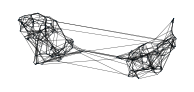

In [4]:
X, y = load_diabetes(return_X_y=True)
p = UMAP(n_neighbors=5).fit(X)
draw_umap(p)
data['diabetes'] = X

SKLearn Iris

c:\Users\jelme\Documents\Development\work\multi_mst\multi_mst\notebooks\lib\drawing.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  s = plt.scatter(xs, ys, c=color, s=size, edgecolors="none", linewidth=0, cmap='viridis', alpha=alpha)


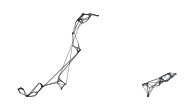

In [5]:
X, y = load_iris(return_X_y=True)
p = UMAP(n_neighbors=5).fit(X)
draw_umap(p)
data['iris'] = X

SKLearn Digits

c:\Users\jelme\Documents\Development\work\multi_mst\multi_mst\notebooks\lib\drawing.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  s = plt.scatter(xs, ys, c=color, s=size, edgecolors="none", linewidth=0, cmap='viridis', alpha=alpha)


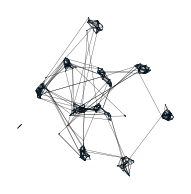

In [6]:
X, y = load_digits(return_X_y=True)
p = UMAP(n_neighbors=5).fit(X)
draw_umap(p)
data['digits'] = X

SKLearn Wine

c:\Users\jelme\Documents\Development\work\multi_mst\multi_mst\notebooks\lib\drawing.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  s = plt.scatter(xs, ys, c=color, s=size, edgecolors="none", linewidth=0, cmap='viridis', alpha=alpha)


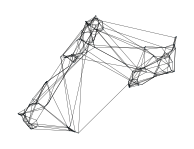

In [7]:
X, y = load_wine(return_X_y=True)
X = RobustScaler().fit_transform(X)
p = UMAP(n_neighbors=5).fit(X)
draw_umap(p)
data['wine'] = X

Horse

c:\Users\jelme\Documents\Development\work\multi_mst\multi_mst\notebooks\lib\drawing.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  s = plt.scatter(xs, ys, c=color, s=size, edgecolors="none", linewidth=0, cmap='viridis', alpha=alpha)


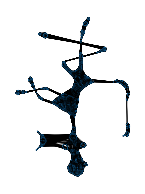

In [8]:
X = pd.read_csv('data/horse/horse.csv').to_numpy()
p = UMAP(n_neighbors=20).fit(X)
draw_umap(p)
data['horse'] = X

MNIST

c:\Users\jelme\Documents\Development\work\multi_mst\multi_mst\notebooks\lib\drawing.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  s = plt.scatter(xs, ys, c=color, s=size, edgecolors="none", linewidth=0, cmap='viridis', alpha=alpha)


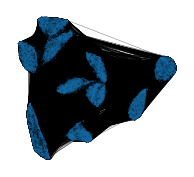

In [9]:
X, target = fetch_openml("mnist_784", version=1, return_X_y=True)
p = UMAP().fit(X)
draw_umap(p)
data['mnist'] = X

## Parameter Sweep

The cell below evaluates all parameters multiple times for each dataset and collects the measurements in a single dataframe.

In [13]:
repeats = 5
neighbours = [2, 3, 4, 6]
min_descent_neighbours = [6, 12, 24, 36]
results = []
for dataset_name in tqdm(data.keys()):
    X = data[dataset_name]

    connected_k = 2
    while True:
        p = UMAP(n_neighbors=connected_k, transform_mode="graph").fit(X)
        if connected_components(p.graph_, directed=False, return_labels=False) == 1:
            break
        connected_k += 1
    data_size = X.shape[0]
    data_dims = X.shape[1]

    for k in neighbours:
        # Compute ground truth
        kmst = KMST(num_neighbors=k).fit(X).umap(transform_mode="graph")
        m1 = kmst.graph_.copy()
        m1.data[:] = 1

        for repeat in range(repeats):
            for n in min_descent_neighbours:
                if n is None:
                    n = k
                elif n < k:
                    continue
                # Compute Descent kMST
                dmst = KMSTDescentLogRecall(
                    num_neighbors=k,
                    min_descent_neighbors=n,
                ).fit(X)
                m2 = dmst.umap(transform_mode="graph").graph_.copy()
                m2.data[:] = 1

                # Extract trace measures
                true_positive = m1.multiply(m2).nnz
                if len(dmst.trace_) == 0:
                    measures = pd.DataFrame(
                        {
                            "dataset": [dataset_name],
                            "boruvka_num_components": [[]],
                            "descent_distance_fraction": [[]],
                            "boruvka_recall": [[]],
                            "boruvka_distance_fraction": [[]],
                            "descent_num_changes": [[]],
                            "descent_recall": [[]],
                        }
                    )
                else:
                    measures = pd.DataFrame(dmst.trace_)
                    measures["boruvka_distance_fraction"] = measures[
                        "descent_distance_fraction"
                    ].apply(lambda x: x[np.argmax(np.isnan(x)) - 1])
                    # Convert to one row with lists
                    measures["dataset"] = dataset_name
                    measures = measures.groupby("dataset").agg(list).reset_index()
                # Add per-run measures
                measures["global_recall"] = true_positive / m1.nnz
                measures["global_precision"] = true_positive / m2.nnz
                measures["global_dist_frac"] = (
                    dmst.graph_.data.sum() / kmst.graph_.data.sum()
                )
                measures["connected_k"] = connected_k
                measures["num_observations"] = data_size
                measures["num_dimensions"] = data_dims
                measures["min_descent_neighbors"] = n
                measures["num_neighbors"] = k
                measures["repeat"] = repeat
                results.append(measures)

results = pd.concat(results, ignore_index=True)
results.head()

100%|██████████| 6/6 [13:35:13<00:00, 8152.23s/it] 


,dataset,boruvka_num_components,boruvka_recall,descent_recall,descent_distance_fraction,descent_num_changes,boruvka_distance_fraction,global_recall,global_precision,global_dist_frac,connected_k,num_observations,num_dimensions,min_descent_neighbors,num_neighbors,repeat
0,diabetes,"[93, 17, 3]","[1.0, 1.0, 1.0]","[[0.9111111, 0.94027776, 0.94861114, 0.95, 0.9...","[[1.0, 1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan,...","[[3072.0, 314.0, 54.0, 8.0, 2.0, nan, nan, nan...","[1.0, 1.0, 1.0]",0.986513,0.986513,0.043145,3,442,10,6,2,0
1,diabetes,"[93, 17, 3]","[1.0, 1.0, 1.0]","[[0.96067417, 0.96348315, 0.96348315, 0.963483...","[[1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan,...","[[4965.0, 87.0, 6.0, 1.0, nan, nan, nan, nan, ...","[1.0, 1.0, 1.0]",1.000000,1.000000,0.043106,3,442,10,12,2,0
2,diabetes,"[93, 17, 3]","[1.0, 1.0, 1.0]","[[0.95694447, 0.95694447, nan, nan, nan, nan, ...","[[1.0, 1.0, nan, nan, nan, nan, nan, nan, nan,...","[[6886.0, 2.0, nan, nan, nan, nan, nan, nan, n...","[1.0, 1.0, 1.0]",1.000000,1.000000,0.043106,3,442,10,24,2,0
3,diabetes,"[93, 17, 3]","[1.0, 1.0, 1.0]","[[0.95111734, 0.95111734, nan, nan, nan, nan, ...","[[1.0, 1.0, nan, nan, nan, nan, nan, nan, nan,...","[[7852.0, 0.0, nan, nan, nan, nan, nan, nan, n...","[1.0, 1.0, 1.0]",1.000000,1.000000,0.043106,3,442,10,36,2,0
4,diabetes,"[93, 17, 3]","[1.0, 1.0, 1.0]","[[0.9044321, 0.9362881, 0.94598335, 0.94598335...","[[1.0006415, 1.0006415, 1.0, 1.0, 1.0, 1.0, na...","[[3038.0, 352.0, 51.0, 13.0, 3.0, 1.0, nan, na...","[1.0, 1.0, 1.0]",0.992293,0.992293,0.043115,3,442,10,6,2,1


In [14]:
results.to_parquet("./data/generated/recall_benchmark.parquet")

## Results

This section creates plots showing our results for each of our questions:

- How accurate is our NN-Descent for constructing $k$-MSTs?
- How accurate is our NN-Descent in finding shortest edges between connected components?
- How do the parameters influence NN-Descent's performance?

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lib.plotting import *
configure_matplotlib()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [17]:
results = pd.read_parquet("./data/generated/recall_benchmark.parquet")
min_descent_neighbours = results.min_descent_neighbors.unique()

In [18]:
results.groupby('dataset').agg({'num_observations': 'first', 'num_dimensions': 'first', 'connected_k': 'first'}).reset_index()

,dataset,num_observations,num_dimensions,connected_k
0,diabetes,442,10,3
1,digits,1797,64,8
2,horse,8431,3,18
3,iris,150,4,26
4,mnist,70000,784,5
5,wine,178,13,4


In [19]:
results["num_boruvka_iters"] = results.boruvka_recall.apply(len)
results["boruvka_iteration"] = results.num_boruvka_iters.apply(lambda x: list(range(x)))

vars = [
    "dataset",
    "repeat",
    "connected_k",
    "num_neighbors",
    "num_observations",
    "min_descent_neighbors",
]
measures = [
    "boruvka_iteration",
    "boruvka_num_components",
    "boruvka_recall",
    "boruvka_distance_fraction",
    "descent_num_changes",
    "descent_recall",
    "descent_distance_fraction",
]
exploded = results[vars + measures].explode(measures).reset_index(drop=True)

In [20]:
exploded['num_descent_iters'] = exploded.descent_recall.apply(lambda x: len(x) if hasattr(x, '__len__') else 0)
exploded['descent_converged'] = exploded.num_descent_iters != exploded.descent_recall.apply(lambda x: np.argmax(np.isnan(x)))
exploded['descent_iteration'] = exploded.num_descent_iters.apply(lambda x: list(range(x)))

vars = ['dataset', 'repeat', 'connected_k', 'num_neighbors', 'min_descent_neighbors', 'boruvka_num_components', 'boruvka_iteration', 'descent_converged']
measures = ['descent_iteration', 'descent_num_changes', 'descent_recall', 'descent_distance_fraction']
twice_exploded = exploded[vars + measures].explode(measures).reset_index(drop=True)

In [21]:
exploded['descent_final_recall'] = exploded.descent_recall.apply(lambda x: x[np.argmax(np.isnan(x)) - 1] if hasattr(x, '__len__') else np.nan)
exploded['descent_final_dist_frac'] = exploded.descent_distance_fraction.apply(lambda x: x[np.argmax(np.isnan(x)) - 1] if hasattr(x, '__len__') else np.nan)
exploded['descent_final_changes'] = exploded.descent_num_changes.apply(lambda x: x[np.argmax(np.isnan(x)) - 1] if hasattr(x, '__len__') else np.nan)

### How accurate is our NN-Descent for constructing $k$-MSTs?

The globall recall was high (>0.94) in all cases, which is a promising result.
There are two concerns:

1. Most edges in the $k$-MST are from the $k$-NN, so global recall mostly
   reflects how well $k$-NN are found, rather than the MST edges.
2. The global recall was worse at low $k$ for a difficult dataset (with high
   connected_k). This is a dataset that requires the MST stage to find the
   appropriate edges, as they are not included in the nearest neighbors. So, a
   worse performance at low $k$ indicates our approach did not find the nearest
   neighbors. The increasing recall at higher $k$ indicates that the higher
   neighbours were detected.

In [22]:
dataset_order = ["iris", "wine", "diabetes", "digits", "horse", "mnist"]
display_name = dict(
    iris="Iris",
    wine="Wine",
    diabetes="Diabetes",
    digits="Digits",
    horse="Horse",
    mnist="MNIST",
)

In [23]:
results.groupby(["dataset", "num_neighbors"]).global_recall.mean().unstack().reindex(
    dataset_order
).round(2)

num_neighbors,2,3,4,6
dataset,,,,
iris,0.95,0.95,0.97,0.95
wine,1.00,1.00,1.00,1.00
diabetes,1.00,1.00,0.99,1.00
digits,0.99,0.99,0.99,0.99
horse,1.00,1.00,1.00,1.00
mnist,0.99,0.97,0.97,0.97


Another way to measure the quality of our approximate $k$-MST is by comparing
the total distance over its edges to the ground-truth $k$-MST. The figure below
show the approximate total distance divided by the true total distance. An
optimal solution has a value of $1$. Higher values are worse, lower values
happen when non-exact approximate edges connect components not yet connected by
ground truth edges. Again the most difficult dataset is most different from $1$
lower $k$, indicating we did not find the exact MST edges.

In [24]:
results.groupby(["dataset", "num_neighbors"]).global_dist_frac.mean().unstack().reindex(
    dataset_order
).round(2)

num_neighbors,2,3,4,6
dataset,,,,
iris,0.19000,0.220000,0.24000,0.270000
wine,0.90000,0.990000,1.05000,1.090000
diabetes,0.04000,0.050000,0.05000,0.060000
digits,10.89000,11.800000,12.42000,13.300000
horse,0.00000,0.010000,0.01000,0.010000
mnist,639.22998,678.619995,702.76001,736.119995


### How accurate is our NN-Descent?

Instead of looking at the global $k$-MST, lets zoom in to the Boruvka algorithm
and see how well we found the edges we are looking for. Here we see that 
the Iris dataset gave the lowest recall. This is also the dataset with the 
highest connecting $k$, meaning that the MST stage is actually required!

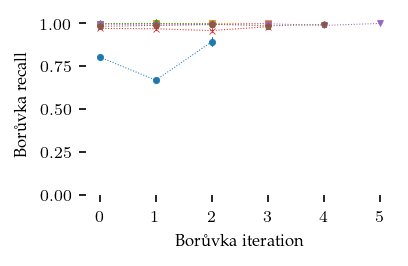

In [25]:
sized_fig(1/2)
sns.pointplot(
    exploded,
    x="boruvka_iteration",
    y="boruvka_recall",
    hue='dataset',
    hue_order=dataset_order,
    ci=95,
    units="repeat",
    markers=['o', 's', 'd', 'x',  'v', 'p'],
    linewidth=0.5,
    linestyle=':',
    markersize=3,
    palette="tab10",
    native_scale=True,
    legend=False,
)
plt.ylim([0, 1.05])
plt.ylabel('Bor\\r{u}vka recall')
plt.xlabel('Bor\\r{u}vka iteration')
plt.subplots_adjust(0.2, 0.24, 0.95, 0.95)
plt.savefig('images/boruvka_recall_vs_iterations.pdf')
plt.show()

In [26]:
exploded.groupby(['dataset', 'boruvka_iteration']).boruvka_recall.mean().unstack().reindex(dataset_order)

boruvka_iteration,0,1,2,3,4,5
dataset,,,,,,
iris,0.803427,0.66934,0.893403,NaN,NaN,NaN
wine,0.999453,1.0,1.0,1.0,NaN,NaN
diabetes,0.999115,1.0,0.997917,NaN,NaN,NaN
digits,0.970977,0.968882,0.958517,0.981042,NaN,NaN
horse,0.997149,0.99038,0.992793,0.998381,0.988462,1.0
mnist,0.982824,0.988905,0.995083,0.985923,0.994375,NaN


The recall in the descent stage tells a different story, indicating that finding
connecting edges for points that are not part of the shortest edge between
components is more difficult.

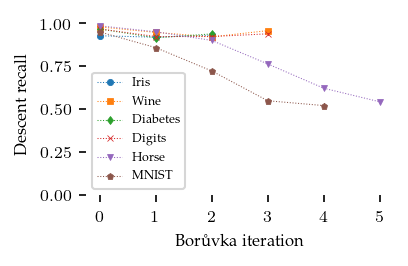

In [27]:
sized_fig(1/2)
display = exploded.copy()
display['dataset'].replace(display_name, inplace=True)
sns.pointplot(
    display,
    x="boruvka_iteration",
    y="descent_final_recall",
    hue='dataset',
    hue_order=[display_name[l] for l in dataset_order],
    ci=95,
    units="repeat",
    markers=['o', 's', 'd', 'x',  'v', 'p'],
    linewidth=0.5,
    linestyle=':',
    markersize=3,
    palette="tab10",
    native_scale=True
)
plt.legend(title='')
plt.ylim([0, 1.05])
plt.ylabel('Descent recall')
plt.xlabel('Bor\\r{u}vka iteration')
plt.subplots_adjust(0.2, 0.24, 0.95, 0.95)
plt.savefig('images/descent_recall_vs_iteration.pdf')
plt.show()

### How do the parameters influence NN-Descent's performance?

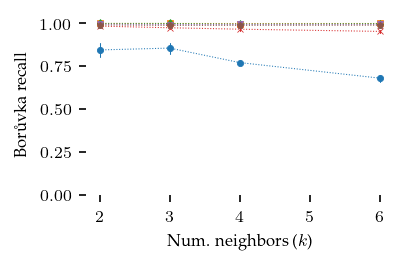

In [28]:
sized_fig(1/2)
sns.pointplot(
    exploded,
    x="num_neighbors",
    y="boruvka_recall",
    hue='dataset',
    hue_order=dataset_order,
    ci=95,
    units="repeat",
    markers=['o', 's', 'd', 'x',  'v', 'p'],
    linewidth=0.5,
    linestyle=':',
    markersize=3,
    palette="tab10",
    native_scale=True,
    legend=False,
)
plt.ylim([0, 1.05])
plt.ylabel('Bor\\r{u}vka recall')
plt.xlabel('Num. neighbors ($k$)')
plt.subplots_adjust(0.2, 0.24, 0.95, 0.95)
plt.savefig('images/boruvka_recall_vs_neighbors.pdf')
plt.show()

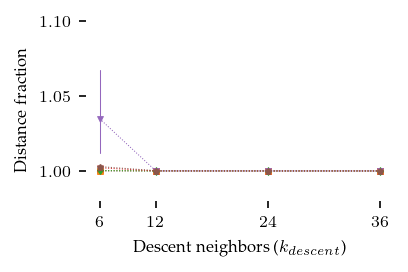

In [29]:
sized_fig(1/2)
sns.pointplot(
    exploded,
    x="min_descent_neighbors",
    y="boruvka_distance_fraction",
    hue='dataset',
    hue_order=dataset_order,
    ci=95,
    units="repeat",
    markers=['o', 's', 'd', 'x',  'v', 'p'],
    linewidth=0.5,
    linestyle=':',
    markersize=3,
    palette="tab10",
    legend=False,
    native_scale=True
)
plt.ylim([0.98, 1.1])
plt.yticks([1, 1.05, 1.1])
plt.xticks(min_descent_neighbours)
plt.ylabel('Distance fraction')
plt.xlabel('Descent neighbors ($k_{descent}$)')
plt.subplots_adjust(0.2, 0.24, 0.95, 0.95)
plt.savefig('images/boruvka_dist_fract_vs_descent_neighbors.pdf', pad_inches=0)
plt.show()

### How did the descent stage converge?

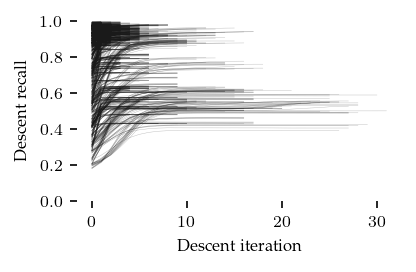

In [30]:
fig = sized_fig(1/2)
for n, k_d in enumerate(twice_exploded.min_descent_neighbors.unique()):
    for i, it in enumerate(twice_exploded.boruvka_iteration.unique()):
        if np.isnan(i):
            continue
        for dataset in twice_exploded.dataset.unique():
            for k in twice_exploded.num_neighbors.unique():
                for r in twice_exploded.repeat.unique():
                    d = twice_exploded.query(
                        f"dataset == '{dataset}' and num_neighbors == {k} and min_descent_neighbors == {k_d} and boruvka_iteration == {it} and repeat == {r}"
                    )
                    plt.plot(
                        d.descent_iteration,
                        d.descent_recall,
                        linewidth=0.2,
                        alpha=0.3,
                        color="k",
                    )
        # plt.vlines(x=exploded.descent_recall.apply(len).max(), ymin=0, ymax=1, color="r", linestyle="--")
        plt.ylim([0, 1])
        # plt.xlim([0, 50])
        # plt.xticks([0, 25, 50])
plt.ylabel('Descent recall')
plt.xlabel('Descent iteration')        
plt.subplots_adjust(0.16, 0.24, 0.95, 0.95)
plt.savefig('images/descent_convergence.pdf', pad_inches=0)
plt.show()